In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb

# MLflow imports
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient

# Hyperparameter tuning
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import warnings
warnings.filterwarnings('ignore')

print(f"MLflow version: {mlflow.__version__}")

MLflow version: 3.5.1


In [34]:
# Set MLflow Tracking
# This sets where MLflow will store experiment data
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("video_game_sales_prediction")

print("MLflow tracking configured!")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {mlflow.get_experiment_by_name('video_game_sales_prediction')}")

MLflow tracking configured!
Tracking URI: sqlite:///mlflow.db
Experiment: <Experiment: artifact_location='/Users/zankhanamehta/Documents/NEU/MLOps/MLOps_labs/Mlflow_lab/mlruns/1', creation_time=1762026483632, experiment_id='1', last_update_time=1762026483632, lifecycle_stage='active', name='video_game_sales_prediction', tags={'mlflow.experimentKind': 'custom_model_development'}>


## Data Exploration

In [35]:
df = pd.read_csv('data.csv')

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
display(df.head())

print(f"\nColumn names and types:")
display(df.dtypes)

print(f"\nBasic statistics:")
display(df.describe())

Dataset loaded successfully!

Dataset shape: (16598, 11)

First few rows:


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37



Column names and types:


Rank              int64
Name             object
Platform         object
Year            float64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object


Basic statistics:


,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16327.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,8300.605254,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [36]:
print("🔍 Missing Values Analysis:")
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})
display(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

print(f"\nTotal missing values: {df.isnull().sum().sum()}")

🔍 Missing Values Analysis:


,Missing Count,Percentage
Year,271,1.632727
Publisher,58,0.349440



Total missing values: 329


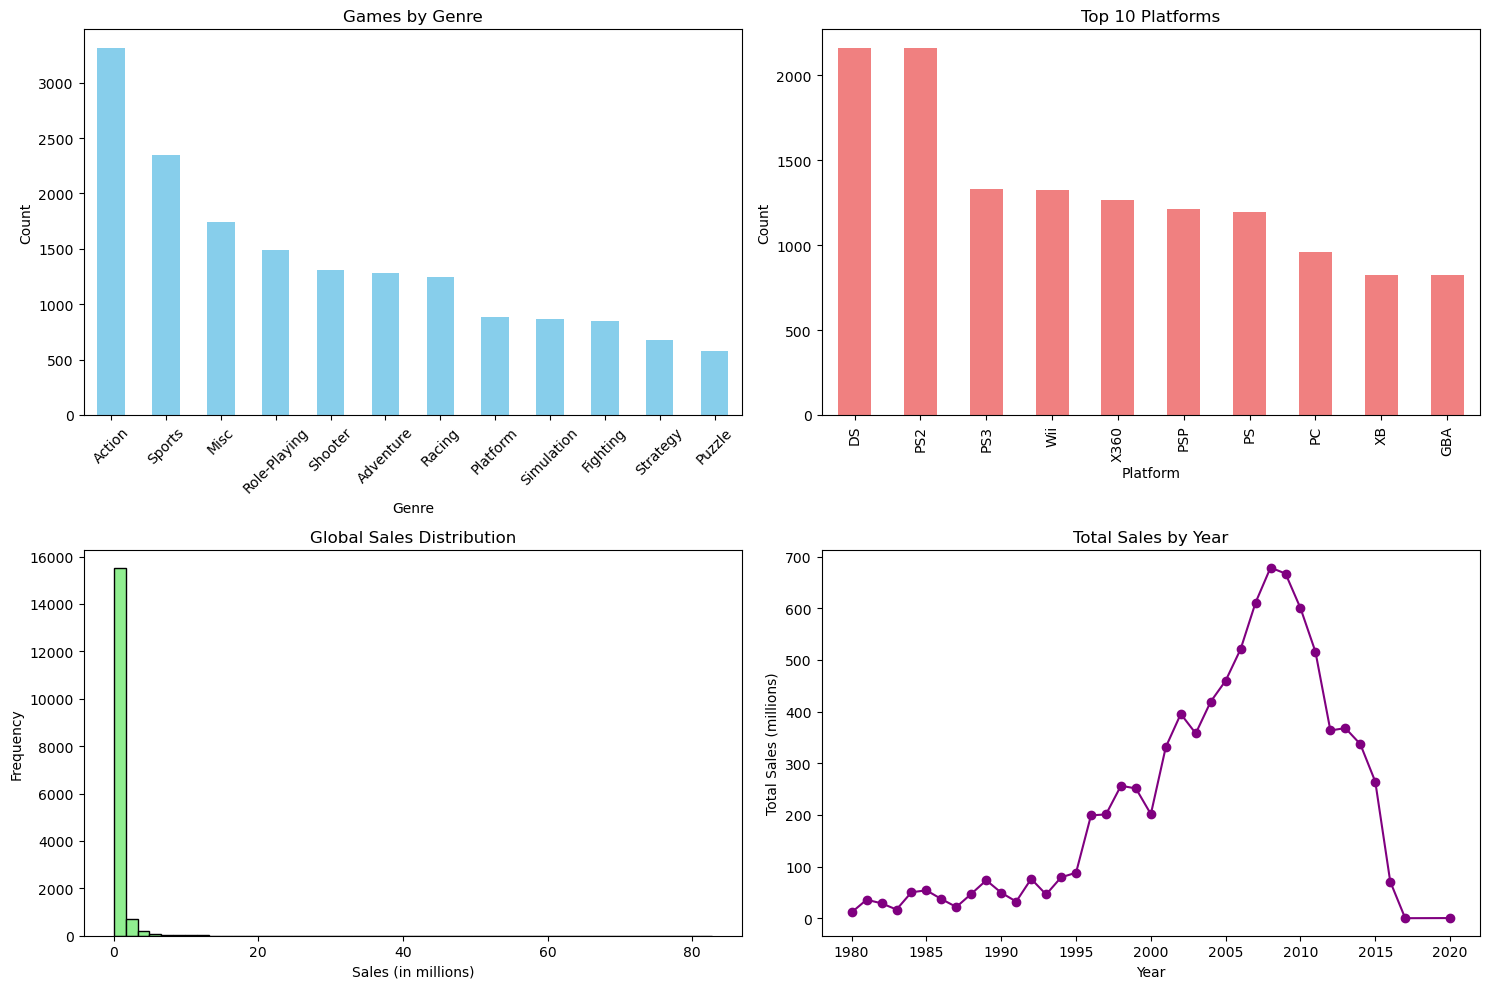

In [37]:
# Visualize the data distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Genre distribution
df['Genre'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Games by Genre')
axes[0, 0].set_xlabel('Genre')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Platform distribution (top 10)
df['Platform'].value_counts().head(10).plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Top 10 Platforms')
axes[0, 1].set_xlabel('Platform')
axes[0, 1].set_ylabel('Count')

# Global sales distribution
axes[1, 0].hist(df['Global_Sales'], bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Global Sales Distribution')
axes[1, 0].set_xlabel('Sales (in millions)')
axes[1, 0].set_ylabel('Frequency')

# Sales by year
sales_by_year = df.groupby('Year')['Global_Sales'].sum()
sales_by_year.plot(kind='line', ax=axes[1, 1], color='purple', marker='o')
axes[1, 1].set_title('Total Sales by Year')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Total Sales (millions)')

plt.tight_layout()
plt.show()


In [38]:
# Data Cleaning
# Drop rows with missing Year (can't predict without year info)
df_clean = df.dropna(subset=['Year']).copy()

# Fill missing Publisher with 'Unknown'
df_clean['Publisher'].fillna('Unknown', inplace=True)

print(f"Data cleaned!")
print(f"Original shape: {df.shape}")
print(f"After cleaning: {df_clean.shape}")
print(f"Rows removed: {df.shape[0] - df_clean.shape[0]}")

# Create binary target: Blockbuster game (>1M global sales) vs Regular game
# This is what we'll predict!
df_clean['is_blockbuster'] = (df_clean['Global_Sales'] >= 1.0).astype(int)

print(f"\nTarget Variable Created!")
print(f"Blockbusters (>=1M sales): {df_clean['is_blockbuster'].sum()}")
print(f"Regular games (<1M sales): {(df_clean['is_blockbuster']==0).sum()}")
print(f"Blockbuster percentage: {df_clean['is_blockbuster'].mean()*100:.1f}%")

Data cleaned!
Original shape: (16598, 11)
After cleaning: (16327, 11)
Rows removed: 271

Target Variable Created!
Blockbusters (>=1M sales): 2059
Regular games (<1M sales): 14268
Blockbuster percentage: 12.6%


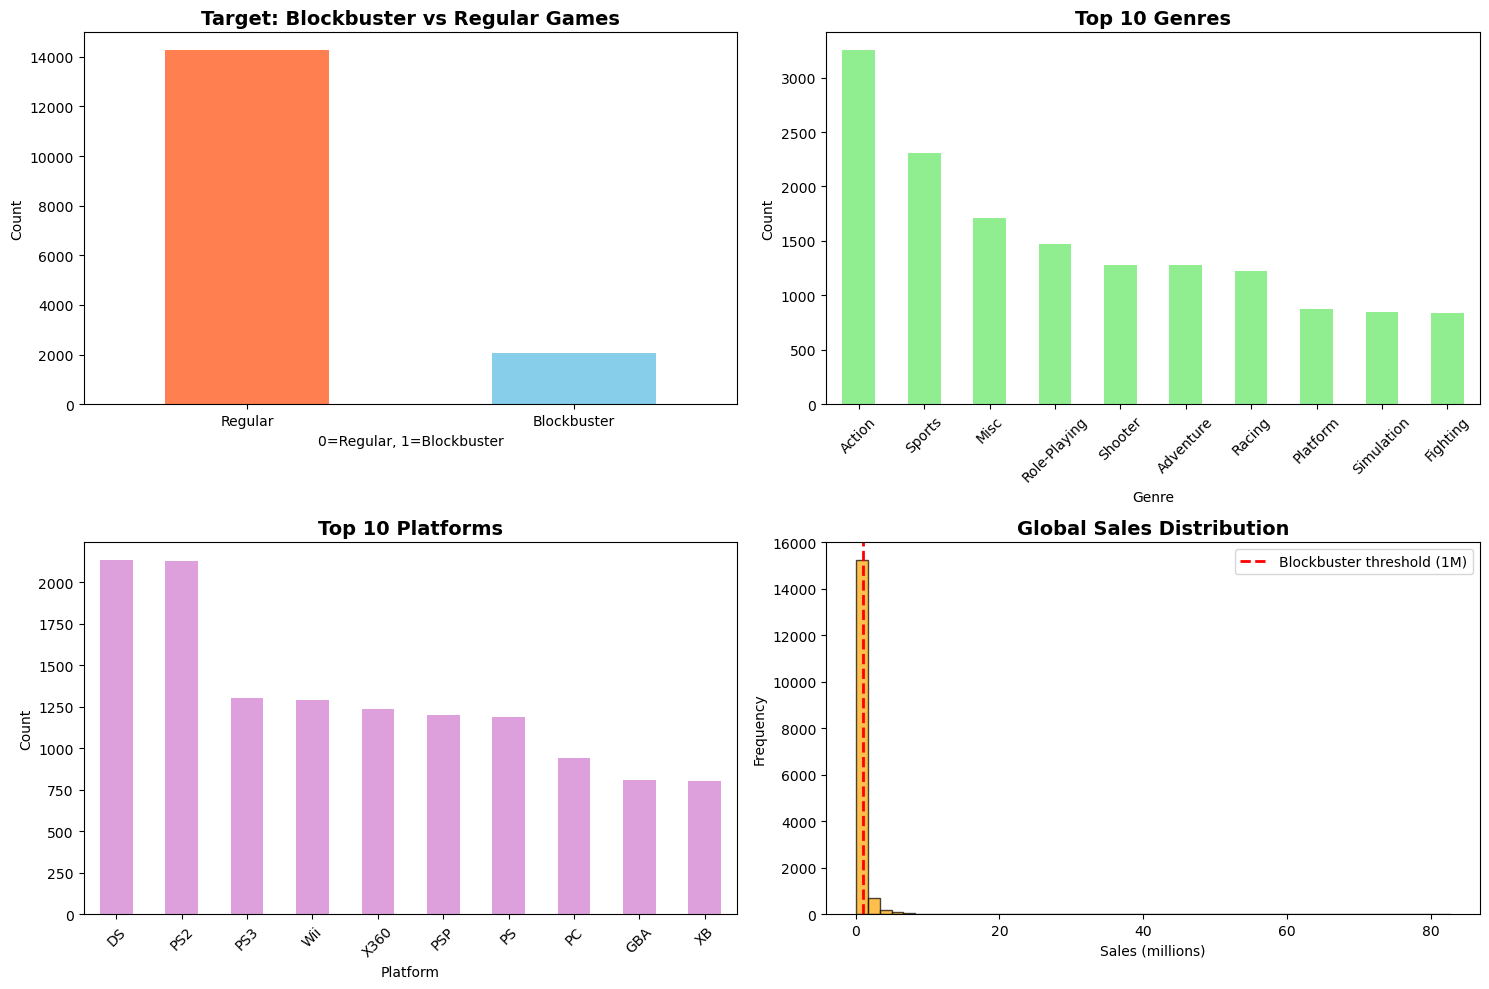

Visualizations complete!


In [39]:
# Visualize our target and key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Target distribution
df_clean['is_blockbuster'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['coral', 'skyblue'])
axes[0, 0].set_title('Target: Blockbuster vs Regular Games', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('0=Regular, 1=Blockbuster')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticklabels(['Regular', 'Blockbuster'], rotation=0)

# Genre distribution
df_clean['Genre'].value_counts().head(10).plot(kind='bar', ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Top 10 Genres', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Genre')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Platform distribution
df_clean['Platform'].value_counts().head(10).plot(kind='bar', ax=axes[1, 0], color='plum')
axes[1, 0].set_title('Top 10 Platforms', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Platform')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Sales distribution
axes[1, 1].hist(df_clean['Global_Sales'], bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Blockbuster threshold (1M)')
axes[1, 1].set_title('Global Sales Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sales (millions)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("Visualizations complete!")

In [40]:
print("Feature Engineering...")

# Select features we'll use for prediction
# We'll use: Platform, Year, Genre, Publisher
features_to_use = ['Platform', 'Year', 'Genre', 'Publisher']

# Create feature dataframe
X = df_clean[features_to_use].copy()
y = df_clean['is_blockbuster'].copy()

print(f"Features selected: {features_to_use}")
print(f"\nFeature shapes before encoding:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Check unique values in categorical features
print(f"\nUnique values:")
print(f"Platforms: {X['Platform'].nunique()}")
print(f"Genres: {X['Genre'].nunique()}")
print(f"Publishers: {X['Publisher'].nunique()}")

Feature Engineering...
Features selected: ['Platform', 'Year', 'Genre', 'Publisher']

Feature shapes before encoding:
X shape: (16327, 4)
y shape: (16327,)

Unique values:
Platforms: 31
Genres: 12
Publishers: 576


In [41]:
# Cell 10: Label Encoding for categorical variables
from sklearn.preprocessing import LabelEncoder

# Create a copy for encoding
X_encoded = X.copy()

# Initialize label encoders
label_encoders = {}

# Encode each categorical column
categorical_columns = ['Platform', 'Genre', 'Publisher']

for col in categorical_columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {X[col].nunique()} unique values")

print(f"\nAll categorical features encoded!")
print(f"\nEncoded features sample:")
X_encoded.head()

Encoded Platform: 31 unique values
Encoded Genre: 12 unique values
Encoded Publisher: 576 unique values

All categorical features encoded!

Encoded features sample:


,Platform,Year,Genre,Publisher
0,26,2006.0,10,359
1,11,1985.0,4,359
2,26,2008.0,6,359
3,26,2009.0,10,359
4,5,1996.0,7,359


In [42]:
# Cell 11: Split data into train, validation, and test sets
# 60% train, 20% validation, 20% test

X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Data split completed!")
print(f"\nTraining set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X_encoded)*100:.1f}%)")

print(f"\nClass distribution in training set:")
print(f"Regular games: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"Blockbusters:  {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

Data split completed!

Training set:   9796 samples (60.0%)
Validation set: 3265 samples (20.0%)
Test set:       3266 samples (20.0%)

Class distribution in training set:
Regular games: 8561 (87.4%)
Blockbusters:  1235 (12.6%)


## Baseline Model - Logistic Regression with MLflow

Training Baseline Model: Logistic Regression


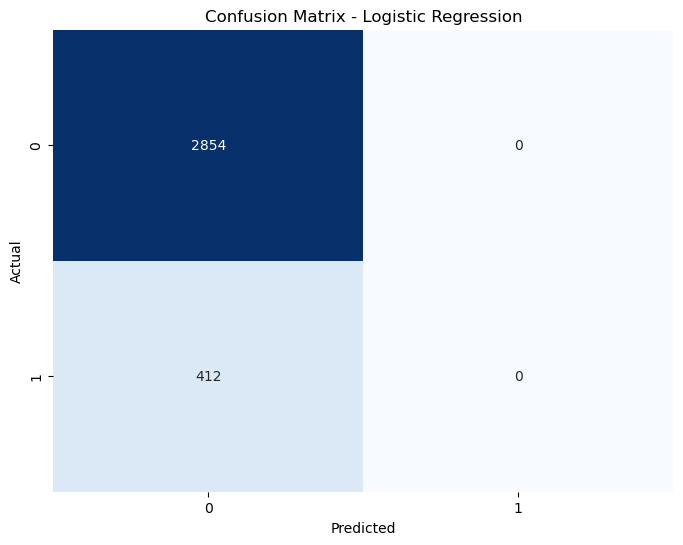

2025/11/01 17:41:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Results:
Train Accuracy:  0.8739
Val Accuracy:    0.8738
Test Accuracy:   0.8739
Test Precision:  0.0000
Test Recall:     0.0000
Test F1 Score:   0.0000

Baseline model trained and logged to MLflow!
Run ID: d803572bc5a440238368bc09d68a8019


In [43]:
# Cell 12: Baseline Model - Logistic Regression with MLflow Tracking

print("Training Baseline Model: Logistic Regression")

# Start an MLflow run
with mlflow.start_run(run_name='logistic_regression_baseline'):
    
    # Train the model
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = lr_model.predict(X_train)
    y_pred_val = lr_model.predict(X_val)
    y_pred_test = lr_model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    
    # Log parameters to MLflow
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("random_state", 42)
    
    # Log metrics to MLflow
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    
    # Create and log confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Logistic Regression')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('confusion_matrix_lr.png')
    mlflow.log_artifact('confusion_matrix_lr.png')
    plt.show()
    
    # Log the model with signature
    signature = infer_signature(X_train, lr_model.predict(X_train))
    mlflow.sklearn.log_model(lr_model, "model", signature=signature)
    
    # Print results
    print(f"\n📊 Results:")
    print(f"Train Accuracy:  {train_accuracy:.4f}")
    print(f"Val Accuracy:    {val_accuracy:.4f}")
    print(f"Test Accuracy:   {test_accuracy:.4f}")
    print(f"Test Precision:  {test_precision:.4f}")
    print(f"Test Recall:     {test_recall:.4f}")
    print(f"Test F1 Score:   {test_f1:.4f}")
    
    print("\nBaseline model trained and logged to MLflow!")
    print(f"Run ID: {mlflow.active_run().info.run_id}")

In [45]:
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Regular', 'Blockbuster']))

Detailed Classification Report:
              precision    recall  f1-score   support

     Regular       0.87      1.00      0.93      2854
 Blockbuster       0.00      0.00      0.00       412

    accuracy                           0.87      3266
   macro avg       0.44      0.50      0.47      3266
weighted avg       0.76      0.87      0.82      3266



## Random Forest Model

Training Random Forest Model


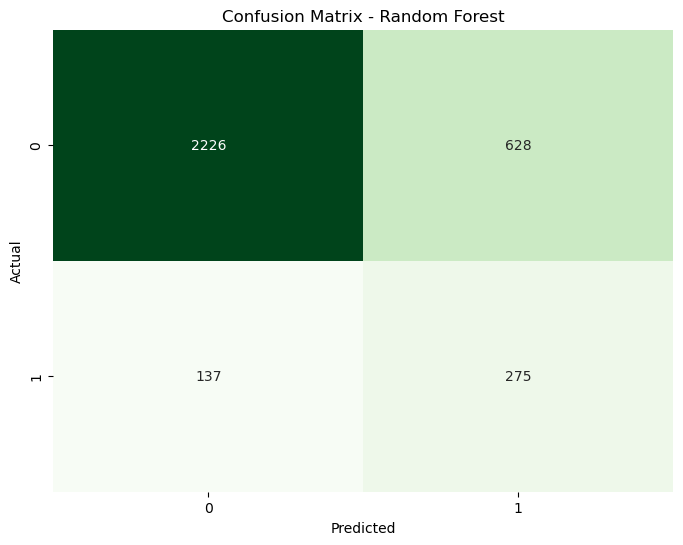

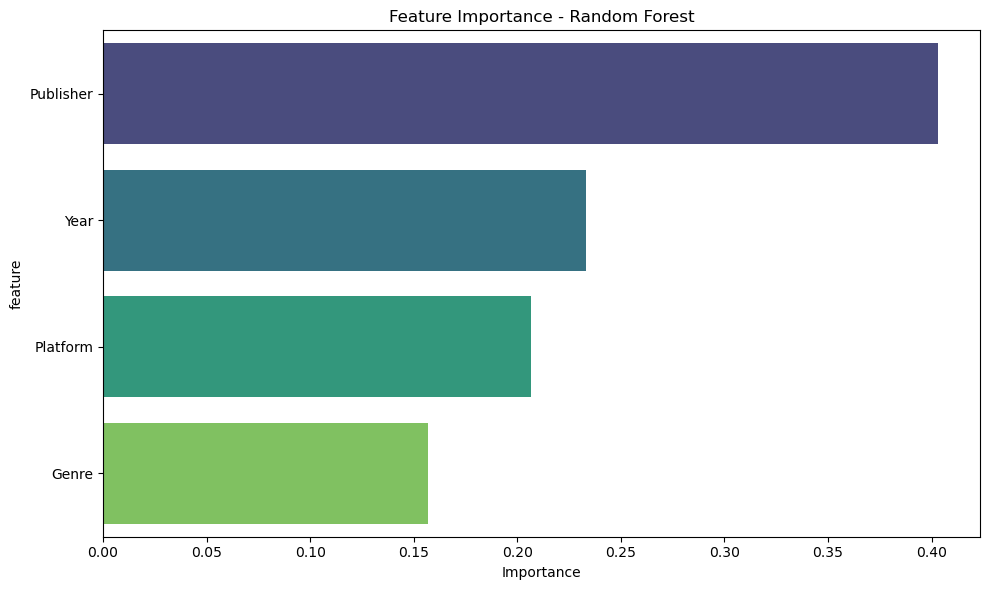

2025/11/01 17:43:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Results:
Train Accuracy:  0.7990
Val Accuracy:    0.7755
Test Accuracy:   0.7658
Test Precision:  0.3045
Test Recall:     0.6675
Test F1 Score:   0.4183

Random Forest model trained and logged to MLflow!
Run ID: 5e26a14b60e34204ba35f4b518574cbb

Classification Report:
              precision    recall  f1-score   support

     Regular       0.94      0.78      0.85      2854
 Blockbuster       0.30      0.67      0.42       412

    accuracy                           0.77      3266
   macro avg       0.62      0.72      0.64      3266
weighted avg       0.86      0.77      0.80      3266



In [46]:
# Random Forest Model with MLflow Tracking

print("Training Random Forest Model")

# Start an MLflow run
with mlflow.start_run(run_name='random_forest_baseline'):
    
    # Train the model
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'  # This helps with imbalanced data!
    )
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_val = rf_model.predict(X_val)
    y_pred_test = rf_model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    
    # Log parameters to MLflow
    mlflow.log_param("model_type", "Random Forest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("min_samples_split", 5)
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    
    # Log metrics to MLflow
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    
    # Create and log confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title('Confusion Matrix - Random Forest')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('confusion_matrix_rf.png')
    mlflow.log_artifact('confusion_matrix_rf.png')
    plt.show()
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
    plt.title('Feature Importance - Random Forest')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importance_rf.png')
    mlflow.log_artifact('feature_importance_rf.png')
    plt.show()
    
    # Log the model with signature
    signature = infer_signature(X_train, rf_model.predict(X_train))
    mlflow.sklearn.log_model(rf_model, "model", signature=signature)
    
    # Print results
    print(f"\n📊 Results:")
    print(f"Train Accuracy:  {train_accuracy:.4f}")
    print(f"Val Accuracy:    {val_accuracy:.4f}")
    print(f"Test Accuracy:   {test_accuracy:.4f}")
    print(f"Test Precision:  {test_precision:.4f}")
    print(f"Test Recall:     {test_recall:.4f}")
    print(f"Test F1 Score:   {test_f1:.4f}")
    
    print("\nRandom Forest model trained and logged to MLflow!")
    print(f"Run ID: {mlflow.active_run().info.run_id}")
    
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Regular', 'Blockbuster']))

## XGBoost Model

Training XGBoost Model
Scale pos weight: 6.93


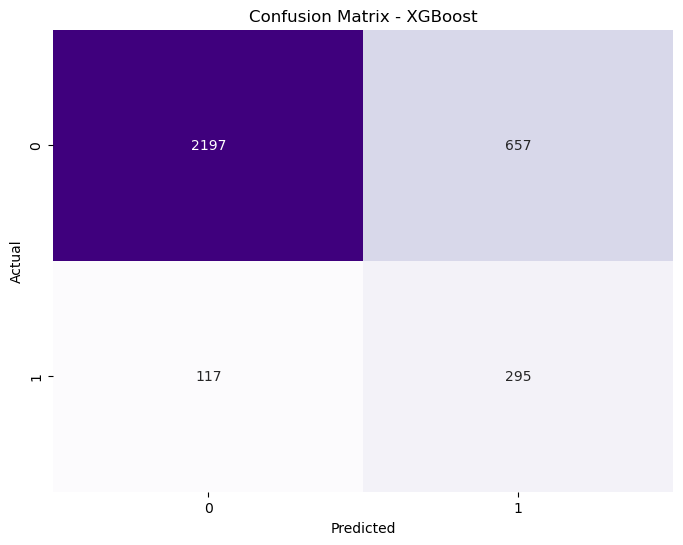

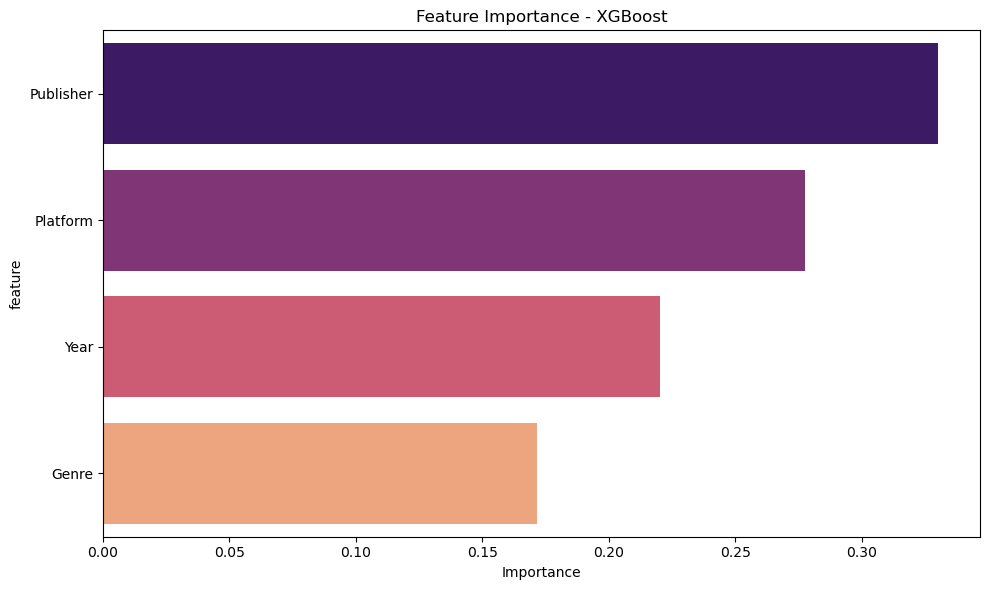

2025/11/01 17:44:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results:
Train Accuracy:  0.8009
Val Accuracy:    0.7804
Test Accuracy:   0.7630
Test Precision:  0.3099
Test Recall:     0.7160
Test F1 Score:   0.4326

XGBoost model trained and logged to MLflow!
Run ID: 6304680ce9184b68ba0d711e1f4985ab

Classification Report:
              precision    recall  f1-score   support

     Regular       0.95      0.77      0.85      2854
 Blockbuster       0.31      0.72      0.43       412

    accuracy                           0.76      3266
   macro avg       0.63      0.74      0.64      3266
weighted avg       0.87      0.76      0.80      3266



In [47]:
print("Training XGBoost Model")

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Start an MLflow run
with mlflow.start_run(run_name='xgboost_baseline'):
    
    # Train the model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,  # Handle imbalanced data
        random_state=42,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = xgb_model.predict(X_train)
    y_pred_val = xgb_model.predict(X_val)
    y_pred_test = xgb_model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    
    # Log parameters to MLflow
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("scale_pos_weight", scale_pos_weight)
    mlflow.log_param("random_state", 42)
    
    # Log metrics to MLflow
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1", test_f1)
    
    # Create and log confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
    plt.title('Confusion Matrix - XGBoost')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('confusion_matrix_xgb.png')
    mlflow.log_artifact('confusion_matrix_xgb.png')
    plt.show()
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature', palette='magma')
    plt.title('Feature Importance - XGBoost')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importance_xgb.png')
    mlflow.log_artifact('feature_importance_xgb.png')
    plt.show()
    
    # Log the model with signature
    signature = infer_signature(X_train, xgb_model.predict(X_train))
    mlflow.xgboost.log_model(xgb_model, "model", signature=signature)
    
    # Print results
    print(f"\nResults:")
    print(f"Train Accuracy:  {train_accuracy:.4f}")
    print(f"Val Accuracy:    {val_accuracy:.4f}")
    print(f"Test Accuracy:   {test_accuracy:.4f}")
    print(f"Test Precision:  {test_precision:.4f}")
    print(f"Test Recall:     {test_recall:.4f}")
    print(f"Test F1 Score:   {test_f1:.4f}")
    
    print("\nXGBoost model trained and logged to MLflow!")
    print(f"Run ID: {mlflow.active_run().info.run_id}")
    
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Regular', 'Blockbuster']))

## Model comparison

In [48]:
print("MODEL COMPARISON SUMMARY")

# Search all runs from our experiment
experiment = mlflow.get_experiment_by_name("video_game_sales_prediction")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Select relevant columns
comparison = runs_df[[
    'tags.mlflow.runName',
    'params.model_type',
    'metrics.test_accuracy',
    'metrics.test_precision', 
    'metrics.test_recall',
    'metrics.test_f1'
]].sort_values('metrics.test_f1', ascending=False)

# Rename columns for clarity
comparison.columns = ['Run Name', 'Model Type', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

print(comparison.to_string(index=False))

print("WINNER: Best model based on F1 Score")
best_model = comparison.iloc[0]
print(f"\nModel: {best_model['Model Type']}")
print(f"F1 Score: {best_model['F1 Score']:.4f}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall: {best_model['Recall']:.4f}")

MODEL COMPARISON SUMMARY
                    Run Name          Model Type  Accuracy  Precision   Recall  F1 Score
            xgboost_baseline             XGBoost  0.763013   0.309874 0.716019  0.432551
      random_forest_baseline       Random Forest  0.765769   0.304540 0.667476  0.418251
logistic_regression_baseline Logistic Regression  0.873852   0.000000 0.000000  0.000000
WINNER: Best model based on F1 Score

Model: XGBoost
F1 Score: 0.4326
Accuracy: 0.7630
Precision: 0.3099
Recall: 0.7160


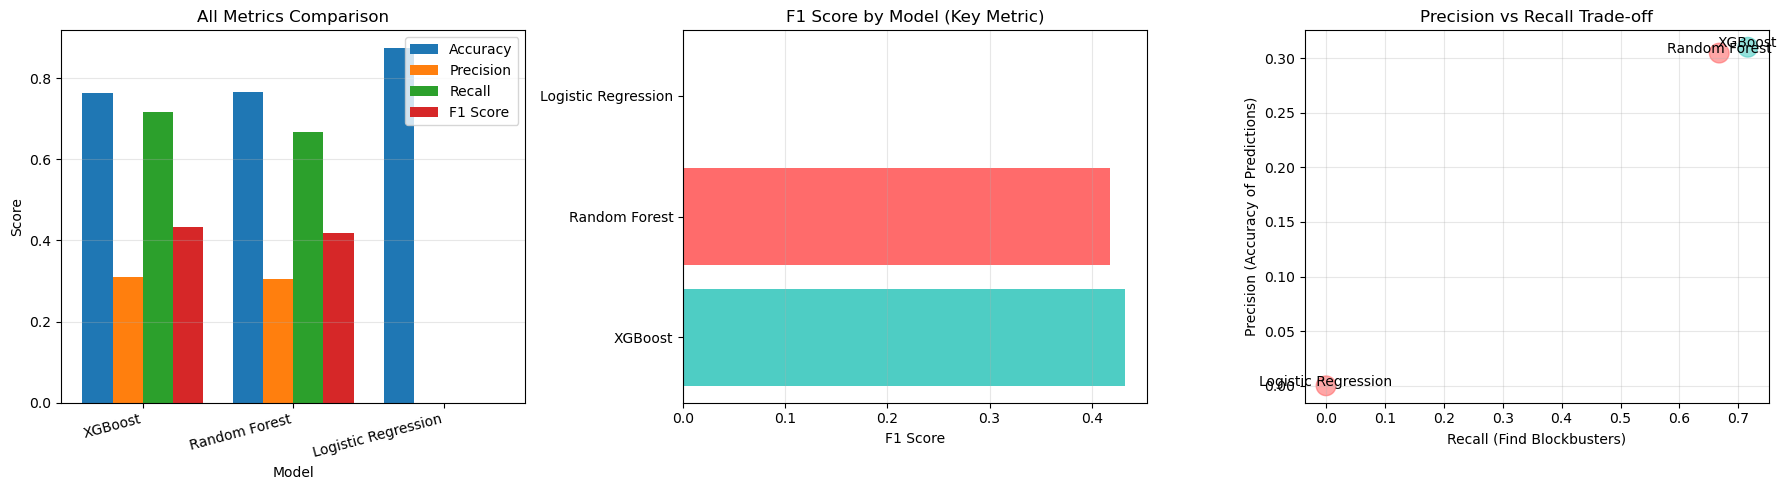

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Prepare data for plotting
models = comparison['Model Type'].tolist()
metrics = {
    'Accuracy': comparison['Accuracy'].tolist(),
    'Precision': comparison['Precision'].tolist(),
    'Recall': comparison['Recall'].tolist(),
    'F1 Score': comparison['F1 Score'].tolist()
}

# Plot 1: All metrics comparison
x = np.arange(len(models))
width = 0.2

for i, (metric_name, values) in enumerate(metrics.items()):
    axes[0].bar(x + i*width, values, width, label=metric_name)

axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('All Metrics Comparison')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: F1 Score comparison (most important for imbalanced data)
colors = ['#ff6b6b' if i > 0 else '#4ecdc4' for i in range(len(models))]
axes[1].barh(models, comparison['F1 Score'], color=colors)
axes[1].set_xlabel('F1 Score')
axes[1].set_title('F1 Score by Model (Key Metric)')
axes[1].grid(axis='x', alpha=0.3)

# Plot 3: Precision vs Recall
axes[2].scatter(comparison['Recall'], comparison['Precision'], s=200, alpha=0.6, c=colors)
for i, model in enumerate(models):
    axes[2].annotate(model, 
                     (comparison['Recall'].iloc[i], comparison['Precision'].iloc[i]),
                     fontsize=10, ha='center')
axes[2].set_xlabel('Recall (Find Blockbusters)')
axes[2].set_ylabel('Precision (Accuracy of Predictions)')
axes[2].set_title('Precision vs Recall Trade-off')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Hyperparameter Tuning with Hyperopt

In [50]:
print("Setting up Hyperparameter Tuning for XGBoost")

# Define the search space
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, -0.5),  # 0.05 to 0.6
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 200, 10)),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 2),  # 0.37 to 7.4
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.loguniform('gamma', -3, 1),  # 0.05 to 2.7
}

print("Search space defined!")
print("\nHyperparameters to tune:")
for param, space in search_space.items():
    print(f"  - {param}")

Setting up Hyperparameter Tuning for XGBoost
Search space defined!

Hyperparameters to tune:
  - max_depth
  - learning_rate
  - n_estimators
  - min_child_weight
  - subsample
  - colsample_bytree
  - gamma


In [51]:
# Objective function for hyperparameter optimization

def objective(params):
    """
    Objective function for Hyperopt to minimize.
    Trains XGBoost with given params and returns validation F1 score.
    """
    
    # Start a nested run for this trial
    with mlflow.start_run(nested=True):
        
        # Create model with trial parameters
        model = xgb.XGBClassifier(
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            n_estimators=int(params['n_estimators']),
            min_child_weight=params['min_child_weight'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            gamma=params['gamma'],
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss',
            verbosity=0  # Suppress output
        )
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred_val = model.predict(X_val)
        
        # Calculate F1 score (our target metric)
        f1 = f1_score(y_val, y_pred_val)
        
        # Log parameters
        mlflow.log_params(params)
        
        # Log metrics
        mlflow.log_metric("val_f1", f1)
        mlflow.log_metric("val_accuracy", accuracy_score(y_val, y_pred_val))
        mlflow.log_metric("val_precision", precision_score(y_val, y_pred_val))
        mlflow.log_metric("val_recall", recall_score(y_val, y_pred_val))
        
        # Return negative F1 (Hyperopt minimizes, we want to maximize F1)
        return {'loss': -f1, 'status': STATUS_OK, 'model': model}

print("Objective function defined!")

Objective function defined!


In [52]:
print("Starting Hyperparameter Optimization")

print("This will run 30 trials - each trial trains a model with different parameters")
print("All trials will be logged to MLflow as nested runs!")
print("\nStarting optimization... ")

# Create a parent run for all hyperparameter tuning trials
with mlflow.start_run(run_name='xgboost_hyperopt_tuning'):
    
    # Initialize Trials object to track progress
    trials = Trials()
    
    # Run optimization
    best_params = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,  # Tree-structured Parzen Estimator
        max_evals=30,  # Number of trials
        trials=trials,
        verbose=False
    )
    
    # Convert best params to correct types
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['n_estimators'] = int(best_params['n_estimators'])
    
    print("\nOptimization complete!")
    print("\nBest hyperparameters found:")

    for param, value in best_params.items():
        print(f"{param:20s}: {value}")
    
    # Get best F1 score
    best_f1 = -min(trials.losses())
    print(f"\n{'Best Validation F1':20s}: {best_f1:.4f}")
    
    # Log best parameters as parent run params
    mlflow.log_params(best_params)
    mlflow.log_metric("best_val_f1", best_f1)

print(" All trials logged to MLflow!")
print(" Check MLflow UI to see all 30 nested runs under 'xgboost_hyperopt_tuning'")

Starting Hyperparameter Optimization
This will run 30 trials - each trial trains a model with different parameters
All trials will be logged to MLflow as nested runs!

Starting optimization... 

Optimization complete!

Best hyperparameters found:
colsample_bytree    : 0.7701240615623839
gamma               : 2.1616159367428764
learning_rate       : 0.10376491809723586
max_depth           : 8
min_child_weight    : 2.2755083387026844
n_estimators        : 100
subsample           : 0.6396762183906443

Best Validation F1  : 0.4612
 All trials logged to MLflow!
 Check MLflow UI to see all 30 nested runs under 'xgboost_hyperopt_tuning'


## Model registry

In [53]:
print("Registering Best Model to MLflow Model Registry")

# Find the best run based on F1 score
experiment = mlflow.get_experiment_by_name("video_game_sales_prediction")
all_runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.test_f1 DESC"]
)

# Get the best run (highest F1 score)
best_run = all_runs.iloc[0]
best_run_id = best_run['run_id']
best_f1 = best_run['metrics.test_f1']
model_name = best_run['tags.mlflow.runName']

print(f"\n🏆 Best Model Found:")
print(f"Run Name: {model_name}")
print(f"Run ID: {best_run_id}")
print(f"Test F1 Score: {best_f1:.4f}")
print(f"Test Accuracy: {best_run['metrics.test_accuracy']:.4f}")
print(f"Test Precision: {best_run['metrics.test_precision']:.4f}")
print(f"Test Recall: {best_run['metrics.test_recall']:.4f}")

# Register the model
model_registry_name = "video_game_blockbuster_predictor"

print(f"\nRegistering model as: '{model_registry_name}'")

model_uri = f"runs:/{best_run_id}/model"
model_version = mlflow.register_model(model_uri, model_registry_name)

print(f"\nModel registered successfully!")
print(f"Model Name: {model_registry_name}")
print(f"Version: {model_version.version}")

import time
time.sleep(2)  # Wait for registration to complete

Registered model 'video_game_blockbuster_predictor' already exists. Creating a new version of this model...
2025/11/01 17:50:55 WARNING mlflow.tracking._model_registry.fluent: Run with id 6304680ce9184b68ba0d711e1f4985ab has no artifacts at artifact path 'model', registering model based on models:/m-447d931c391d4b38a12df53e9f76fc23 instead


Registering Best Model to MLflow Model Registry

🏆 Best Model Found:
Run Name: xgboost_baseline
Run ID: 6304680ce9184b68ba0d711e1f4985ab
Test F1 Score: 0.4326
Test Accuracy: 0.7630
Test Precision: 0.3099
Test Recall: 0.7160

Registering model as: 'video_game_blockbuster_predictor'

Model registered successfully!
Model Name: video_game_blockbuster_predictor
Version: 2


Created version '2' of model 'video_game_blockbuster_predictor'.


In [54]:
# Transition model to Production stage

print("Transitioning Model to Production")

# Initialize MLflow client
client = MlflowClient()

# Transition to Production stage
client.transition_model_version_stage(
    name=model_registry_name,
    version=model_version.version,
    stage="Production"
)

print(f"Model version {model_version.version} transitioned to Production!")
print(f"\nYou can now load this model using:")
print(f'  model = mlflow.pyfunc.load_model("models:/{model_registry_name}/Production")')

Transitioning Model to Production
Model version 2 transitioned to Production!

You can now load this model using:
  model = mlflow.pyfunc.load_model("models:/video_game_blockbuster_predictor/Production")


In [55]:
# Load production model and make predictions

print(" Testing Production Model")

# Load the production model
production_model = mlflow.pyfunc.load_model(f"models:/{model_registry_name}/Production")

# Make predictions on test set
predictions = production_model.predict(X_test)

# Show some sample predictions
print("\nSample Predictions:")
print("="*60)

sample_results = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': predictions[:10],
    'Match': (y_test.values[:10] == predictions[:10])
})
sample_results['Actual_Label'] = sample_results['Actual'].map({0: 'Regular', 1: 'Blockbuster'})
sample_results['Predicted_Label'] = sample_results['Predicted'].map({0: 'Regular', 1: 'Blockbuster'})

print(sample_results[['Actual_Label', 'Predicted_Label', 'Match']].to_string(index=True))

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, predictions)
print(f"\n Production Model Test Accuracy: {test_accuracy:.4f}")

 Testing Production Model

Sample Predictions:
  Actual_Label Predicted_Label  Match
0      Regular         Regular   True
1      Regular         Regular   True
2      Regular     Blockbuster  False
3      Regular         Regular   True
4      Regular         Regular   True
5      Regular         Regular   True
6      Regular         Regular   True
7      Regular         Regular   True
8  Blockbuster     Blockbuster   True
9      Regular         Regular   True

 Production Model Test Accuracy: 0.7630


In [58]:
# Test the served model via REST API

import requests
import json

print("Testing Model Server")

url = 'http://localhost:5001/invocations'
headers = {'Content-Type': 'application/json'}

# Example: PS4 game from 2015, Action genre
data = {
    "dataframe_split": {
        "columns": ["Platform", "Year", "Genre", "Publisher"],
        "data": [[20, 2015.0, 0, 100]]  # Encoded values
    }
}

try:
    response = requests.post(url, headers=headers, data=json.dumps(data))
    prediction = response.json()
    result = 'Blockbuster' if prediction['predictions'][0] == 1 else 'Regular'
    
    print(f"Server Response:")
    print(f"Prediction: {result}")
    print(f"Raw prediction: {prediction}")
    
except Exception as e:
    print(f"Error: {e}")
    print("Make sure the model server is running in terminal!")

Testing Model Server
Server Response:
Prediction: Regular
Raw prediction: {'predictions': [0]}
